In [1]:
# Stdlib packages
import copy
import datetime
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import hist
import mplhep as hep
from cycler import cycler

# ML packages
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

# Module packages
from AMSGrad import AMSGrad
from data_processing import process_data, data_list_index_map
from evaluate import evaluate
from InclusiveNetwork import InclusiveNetwork
from ParticleHLF import ParticleHLF
from space_optimization import optimize_hyperparams
from train import train

gpustat.print_gpustat()
print(torch.cuda.is_available())

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu1.fnal.gov      Wed Aug 21 22:15:40 2024  555.42.02
[0] Tesla P100-PCIE-12GB | 42°C,   0 % |     0 / 12288 MB |
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
SIGNAL_FILEPATHS = [
    lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*",
    # lpc_fileprefix+"/Run3_2022preEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*"]


CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v4'
if VERSION == 'v1':
    CRITERION = "NLLLoss"
    N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
elif VERSION == 'v2':
    # CRITERION == "BCELoss"
    CRITERION = "NLLLoss"
    N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
elif VERSION == 'v3':
    CRITERION = "NLLLoss"
    N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
elif VERSION == 'v4':
    CRITERION = "NLLLoss"
    # N_PARTICLES, N_PARTICLE_FIELDS = 6, 7
    N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
elif VERSION == 'v5':
    CRITERION = "NLLLoss"
    N_PARTICLES, N_PARTICLE_FIELDS = 4, 6
# VARS = 'base_vars'
# CURRENT_TIME = '2024-08-10_10-29-50'
# CURRENT_TIME = '2024-08-17_18-23-49'
VARS = 'extra_vars'
# CURRENT_TIME = '2024-08-10_13-16-12'
# CURRENT_TIME = '2024-08-17_11-45-34'
CURRENT_TIME = '2024-08-20_23-02-48'
# VARS = 'extra_vars_no_dijet_mass'
# CURRENT_TIME = '2024-08-21_15-28-02'
OUTPUT_DIRPATH = CURRENT_DIRPATH + f"/model_outputs/{VERSION}/{VARS}/"

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
PRE_STD = True

In [3]:
if PRE_STD:
    (
        data_df, data_test_df, 
        data_list, data_hlf, label, 
        data_list_test, data_hlf_test, label_test, 
        high_level_fields, input_hlf_vars, hlf_vars_columns,
        data_aux, data_test_aux
    ) = process_data(
        4, 6, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED, return_pre_std=True
    )
else:
    (
        data_list, data_hlf, label, 
        data_list_test, data_hlf_test, label_test, 
        high_level_fields, input_hlf_vars, hlf_vars_columns,
        data_aux, data_test_aux
    ) = process_data(
        4, 6, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED
    )
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (258332, 4, 6)
Data HLF: (258332, 14)
Data list test: (258924, 4, 6)
Data HLF test: (258924, 14)


In [10]:
def plot_train_val_losses(
    IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, sort=None
):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['train_losses_arr'], label=f"Train data losses", 
            alpha=0.7
        )
        plt.plot(
            range(len(IN_info['train_losses_arr'])), 
            IN_info['val_losses_arr'], label=f"Validation data losses", 
            alpha=0.7
        )
    elif method == 'arr':
        linestyles = ['solid', 'dotted']
        linestyles = linestyles * ((2*len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:2*len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['train_losses_arr'][fold_idx], 
                label=f"Train data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx if fold_idx%2 == 0 else fold_idx+1]
            )
            plt.plot(
                range(len(IN_info['train_losses_arr'][fold_idx])), 
                IN_info['val_losses_arr'][fold_idx], 
                label=f"Validation data losses - fold {fold_idx}", alpha=0.5,
                linestyle=linestyles[fold_idx+1 if fold_idx%2 == 0 else fold_idx]
            )
    else:
        raise Exception(f"Must used methods 'std' or 'arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_train_val_losses{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_roc(
    IN_info, plot_prefix, plot_postfix='', method='std', 
    labels=None, yscale='linear', run2=True, sort=None
):
    run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
    run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
    run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.plot(
            IN_info['mean_fprs'], IN_info['base_tpr'], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area'])
        )
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            plt.plot(
                IN_info['fprs'][fold_idx], IN_info['base_tpr'],
                label="Run3 NN - fold %d" % (fold_idx), linestyle=linestyles[fold_idx],
                alpha=0.5
            )
        plt.plot(
            IN_info['mean_fprs'], IN_info['base_tpr'], 
            label="Run3 NN AUC = %.4f" % (IN_info['mean_area']),
            alpha=0.8
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        if sort is not None:
            index_arr = sort
        else:
            index_arr = range(len(IN_info))
        for i in index_arr:
            plt.plot(
                IN_info[i]['mean_fprs'], IN_info[i]['base_tpr'], 
                label=(labels[i]+', ' if labels is not None else '') + "AUC = %.4f" % (IN_info[i]['mean_area']), 
                linestyle=linestyles[i]
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    if run2:
        plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
    if yscale is not None:
        plt.yscale(yscale)
    plt.ylim(0.1, 1.1)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_roc_curve{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def plot_output_score(IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, weights=None):
    plt.figure(figsize=(9,7))
    if method == 'std':
        plt.hist(np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['all_labels']) == 0,1
        ], bins=60, label='ttH background', histtype='step', alpha=0.5, density=True)
        plt.hist(np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['all_labels']) == 1,1
        ], bins=60, label='HH signal', histtype='step', alpha=0.5, density=True)
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            plt.hist(np.exp(
                    IN_info['all_preds'][fold_idx]
                )[
                    np.array(IN_info['all_labels'][fold_idx]) == 0,1
                ], bins=60, label='ttH background'+(' - '+labels[fold_idx] if labels is not None else ''), 
                histtype='step', alpha=0.5, density=True if weights is None else False, weights=weights['bkg'],
                linestyle=linestyles[fold_idx], 
            )
            plt.hist(
                np.exp(
                    IN_info['all_preds'][fold_idx]
                )[
                    np.array(IN_info['all_labels'][fold_idx]) == 1,1
                ], bins=60, label='HH signal'+(' - '+labels[fold_idx] if labels is not None else ''), 
                histtype='step', alpha=0.5, density=True if weights is None else False, weights=weights['sig'], 
                linestyle=linestyles[fold_idx], 
            )
        plt.hist(np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ], bins=60, label='ttH background - avg. over folds', histtype='step', alpha=0.8, 
            density=True if weights is None else False, weights=weights['bkg']
        )
        plt.hist(np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ], bins=60, label='HH signal - avg. over folds', histtype='step', alpha=0.8, 
            density=True if weights is None else False, weights=weights['sig']
        )
    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            plt.hist(
                np.exp(
                    IN_info[i]['all_preds'][0]
                )[
                    np.array(IN_info[i]['all_labels'][0]) == 0, 1
                ], bins=60, 
                label='ttH background'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.75, density=True
            )
            plt.hist(
                np.exp(
                    IN_info[i]['all_preds'][0]
                )[
                    np.array(IN_info[i]['all_labels'][0]) == 1, 1
                ], bins=60, 
                label='HH signal'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.75, density=True
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Counts", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_score_dist{plot_postfix}.png', bbox_inches='tight')
    plt.close()

def s_over_root_b(IN_info, plot_prefix, plot_postfix='', method='arr', labels=None, weights=None):
    plt.figure(figsize=(9,7))
    if method == 'std':
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ]
        plt.hist(sig_np / np.sqrt(bkg_np), bins=60, label='$\frac{s}{\sqrt{b}}', histtype='step', alpha=0.5, density=True)
    elif method == 'arr':
        linestyles = ['dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info['all_preds']) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info['all_preds'])]
        for fold_idx in range(skf.get_n_splits()):
            sig_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 1,1
            ]
            bkg_np = np.exp(
                IN_info['all_preds'][fold_idx]
            )[
                np.array(IN_info['all_labels'][fold_idx]) == 0,1
            ]
            hist_axis = hist.axis.Regular(50, 0., 1., name='var', growth=False, underflow=False, overflow=False)
            sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
            bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
            plt.bar(
                np.arange(0., 1., 0.02), sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten()), 
                label='s / √b'+(' - '+labels[fold_idx] if labels is not None else ''), 
                histtype='step', alpha=0.5, density=True if weights is None else False,
                linestyle=linestyles[fold_idx], 
            )
        sig_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 1,1
        ]
        bkg_np = np.exp(
            IN_info['mean_pred']
        )[
            np.array(IN_info['mean_label']) == 0,1
        ]
        hist_axis = hist.axis.Regular(50, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_np, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_np, weight=weights['bkg'])
        plt.bar(
            np.arange(0., 1., 0.02), sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten()), 
            label='s / √b'+(' - '+labels[fold_idx] if labels is not None else ''), 
            histtype='step', alpha=0.5, density=True if weights is None else False,
            linestyle=linestyles[fold_idx], 
        )

    elif method == 'IN_arr':
        linestyles = ['solid', 'dashed', 'dotted']
        linestyles = linestyles * ((len(IN_info) // len(linestyles)) + 1)
        linestyles = linestyles[:len(IN_info)]
        for i in range(len(IN_info)):
            plt.hist(
                np.exp(
                    IN_info[i]['all_preds'][0]
                )[
                    np.array(IN_info[i]['all_labels'][0]) == 0, 1
                ], bins=60, 
                label='ttH background'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.75, density=True
            )
            plt.hist(
                np.exp(
                    IN_info[i]['all_preds'][0]
                )[
                    np.array(IN_info[i]['all_labels'][0]) == 1, 1
                ], bins=60, 
                label='HH signal'+(' - '+labels[i] if labels is not None else ''), 
                histtype='step', linestyle=linestyles[i], alpha=0.75, density=True
            )
    else:
        raise Exception(f"Must used methods 'std', 'arr', or 'IN_arr'. You used {method}.")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Counts", fontsize=18)
    plt.xlabel("Threshold", fontsize=18)
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.pdf', bbox_inches='tight')
    plt.savefig(f'{plot_prefix}_model_s_over_b{plot_postfix}.png', bbox_inches='tight')
    plt.close()

In [37]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$"
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(20, 0, 1, name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False),
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(50, 25., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'jet1_pt': hist.axis.Regular(40, -10., 4., name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'jet2_pt': hist.axis.Regular(40, -10., 4., name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(40, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -10., 4., name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -10., 4., name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'lepton1_pt': hist.axis.Regular(40, -10., 4., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -10., 4., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -10., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -10., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -10., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -10., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -10., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}

def post_std_np_arrays(
        data, data_test, var_name, index_map, train_index=None, val_index=None
):
    sig_mask = label == 1
    sig_test_mask = label_test == 1
    bkg_mask = label == 0
    bkg_test_mask = label_test == 0
    if train_index is not None and val_index is not None:
        sig_train_mask = sig_mask & train_index 
        sig_val_mask = sig_mask & val_index
        bkg_train_mask = bkg_mask & train_index
        bkg_val_mask = bkg_mask & val_index
        if var_name in (high_level_fields - set(input_hlf_vars)):
            index2, index3 = index_map[var_name]
            sig_train_np = data[sig_train_mask, index2, index3]
            sig_val_np = data[sig_val_mask, index2, index3]
            sig_test_np = data_test[sig_test_mask, index2, index3]
            bkg_train_np = data[bkg_train_mask, index2, index3]
            bkg_val_np = data[bkg_val_mask, index2, index3]
            bkg_test_np = data_test[bkg_test_mask, index2, index3]
        else:
            index2 = hlf_vars_columns[var_name]
            sig_train_np = data[sig_train_mask, index2]
            sig_val_np = data[sig_val_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_train_mask, index2]
            bkg_val_np = data[bkg_val_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]

        return (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np
        )
    elif train_index is None and val_index is None:
        if var_name in (high_level_fields - set(input_hlf_vars)):
            index2, index3 = index_map[var_name]
            sig_train_np = data[sig_mask, index2, index3]
            sig_test_np = data_test[sig_test_mask, index2, index3]
            bkg_train_np = data[bkg_mask, index2, index3]
            bkg_test_np = data_test[bkg_test_mask, index2, index3]
        else:
            index2 = hlf_vars_columns[var_name]
            sig_train_np = data[sig_mask, index2]
            sig_test_np = data_test[sig_test_mask, index2]
            bkg_train_np = data[bkg_mask, index2]
            bkg_test_np = data_test[bkg_test_mask, index2]
        return (
            copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
            copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
        )
    else:
        raise Exception("Either both train_index and val_index must be 'None', or both should not be 'None'. You cannot mix and match.")

def aux_np_arrays(var_name, score_cut, IN_full_eval_dict):
    sig_train_mask = (label == 1) & (
        np.exp(IN_full_eval_dict['train']['mean_pred'])[:, 1] > score_cut
    )
    sig_test_mask = (label_test == 1) & (
        np.exp(IN_full_eval_dict['test']['mean_pred'])[:, 1] > score_cut
    )
    bkg_train_mask = (label == 0) & (
        np.exp(IN_full_eval_dict['train']['mean_pred'])[:, 1] > score_cut
    )
    bkg_test_mask = (label_test == 0) & (
        np.exp(IN_full_eval_dict['test']['mean_pred'])[:, 1] > score_cut
    )

    sig_train_np = data_aux.loc[sig_train_mask, var_name].to_numpy()
    sig_test_np = data_test_aux.loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_aux.loc[bkg_train_mask, var_name].to_numpy()
    bkg_test_np = data_test_aux.loc[bkg_test_mask, var_name].to_numpy()

    return (
        copy.deepcopy(sig_train_np), copy.deepcopy(sig_test_np), 
        copy.deepcopy(bkg_train_np), copy.deepcopy(bkg_test_np)
    )

def make_input_plot(output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, plot_prefix='', plot_postfix='', alpha=0.8, linestyle=True):
    fig, ax = plt.subplots()
    if linestyle:
        if fold_idx is not None:
            linestyles = ["solid", "dashed", "dotted", "solid", "dashed", "dotted"]
        else:
            linestyles = ["solid", "dotted", "solid", "dotted"]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
    else:
        linestyles = None
    hep.histplot(
        hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
        linestyle=linestyles, label=labels, alpha=alpha
    )
    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))
    # Make angular and chi^2 plots linear, otherwise log
    if re.match('chi_t', var_name) is None and re.match('DeltaPhi', var_name) is None and re.match('mass', var_name) is None:
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    ax.set_yscale('linear')
    # Save out the plot
    if fold_idx is not None:
        output_dir = output_dir + "fold/"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')
    plt.close()

### Run the optimization

In [4]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

if CRITERION == "NLLLoss":
    train_weights = torch.FloatTensor(
        [1.0, np.sum(data_aux.loc[label==0,'eventWeight']) / np.sum(data_aux.loc[label==1,'eventWeight'])]
    ).cuda()
    criterion = nn.NLLLoss(weight=train_weights)
elif CRITERION == "BCELoss":
    train_weights = torch.FloatTensor(data_aux.loc[:, "eventWeight"]).cuda()
    criterion = nn.BCELoss(weight=train_weights)
else:
    raise Exception(f"CRITERION must be either 'NLLLoss' or 'BCELoss'. You provided {CRITERION}.")

if OPTIMIZE_SPACE:
    config_file = OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json'
    best_conf = optimize_hyperparams(
        skf, data_list, data_hlf, label, 
        config_file, epochs=10,
        criterion=criterion
    )
    print(best_conf)
else:
    # with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
    # with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
    with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
        best_conf = json.load(f)
        print(best_conf)

NUM_EPOCHS = 150
fom = []
train_losses_arr, val_losses_arr = [], []
for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    model_file = OUTPUT_DIRPATH + CURRENT_TIME +'_ReallyTopclassStyle_'+ f'{fold_idx}.torch'
    state_file = OUTPUT_DIRPATH + CURRENT_TIME +'_BestPerfReallyTopclass_'+ f'{fold_idx}.torch'

    if CRITERION == "NLLLoss":
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        sig_train_mask = rectified_train_index & (label == 1)
        bkg_train_mask = rectified_train_index & (label == 0)
        train_weights = torch.FloatTensor(
            [1.0, np.sum(data_aux.loc[bkg_train_mask,'eventWeight']) / np.sum(data_aux.loc[sig_train_mask,'eventWeight'])]
        ).cuda()
        criterion = nn.NLLLoss(weight=train_weights)
    elif CRITERION == "BCELoss":
        train_weights = torch.FloatTensor((data_aux.iloc[train_index]).loc[:, "eventWeight"]).cuda()
        criterion = nn.BCELoss(weight=train_weights)
        
    model = InclusiveNetwork(
        best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g'], 
        dnn_input=np.shape(data_hlf)[-1], rnn_input=np.shape(data_list)[-1]
    ).cuda()
    optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'], weight_decay=best_conf['L2_reg'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    train_loader = DataLoader(
        ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    val_loader = DataLoader(
        ParticleHLF(data_list[val_index], data_hlf[val_index], label[val_index]), 
        batch_size=best_conf['batch_size'], shuffle=True
    )
    data_loader = {"training": train_loader, "validation": val_loader} 

    best_acc, train_losses, val_losses = train(
        NUM_EPOCHS, model, criterion, optimizer, scheduler, 
        state_file, model_file, data_loader=data_loader
    )
    train_losses_arr.append(train_losses)
    val_losses_arr.append(val_losses)

    fom.append(best_acc)

Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
print("Average best_acc across k-fold: {}".format(Y))
model = InclusiveNetwork(
    best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
    best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']
).cuda()

{'hidden_layers': 2, 'initial_nodes': 500, 'dropout': 0.27817607062770483, 'gru_layers': 2, 'gru_size': 500, 'dropout_g': 0.6184468141076988, 'learning_rate': 0.004851812500501461, 'batch_size': 4000, 'L2_reg': 0.0001}
Epoch 0/149


/uscms_data/d3/tsievert/XHYbbgg/HHtobbyy/AMSGrad.py:86: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706619781071/work/torch/csrc/utils/python_arg_parser.cpp:1519.)
  grad = grad.add(group['weight_decay'], p.data)


training Loss: 0.0001 Acc: 55.8116
validation Loss: 0.0000 Acc: 64.3622
Saving..
Epoch 1/149
training Loss: 0.0000 Acc: 68.1697
validation Loss: 0.0000 Acc: 73.4008
Saving..
Epoch 2/149
training Loss: 0.0000 Acc: 70.2054
validation Loss: 0.0000 Acc: 74.0356
Saving..
Epoch 3/149
training Loss: 0.0000 Acc: 70.3027
validation Loss: 0.0000 Acc: 70.4395
Epoch 4/149
training Loss: 0.0000 Acc: 70.7822
validation Loss: 0.0000 Acc: 71.8118
Epoch 5/149
training Loss: 0.0000 Acc: 71.2462
validation Loss: 0.0000 Acc: 72.7389
Epoch 6/149
training Loss: 0.0000 Acc: 71.7504
validation Loss: 0.0000 Acc: 73.9950
Epoch 7/149
training Loss: 0.0000 Acc: 71.5220
validation Loss: 0.0000 Acc: 69.6208
Epoch 8/149
training Loss: 0.0000 Acc: 72.1167
validation Loss: 0.0000 Acc: 73.4840
Epoch 9/149
training Loss: 0.0000 Acc: 71.8525
validation Loss: 0.0000 Acc: 70.1376
Epoch 10/149
training Loss: 0.0000 Acc: 71.5569
validation Loss: 0.0000 Acc: 72.1253
Epoch 11/149
training Loss: 0.0000 Acc: 72.3349
validation L

### Performance on test set

In [5]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
try:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, 
        train_losses_arr=train_losses_arr, val_losses_arr=val_losses_arr, save=True
    )
except:
    IN_perf = evaluate(
        data_list_test, data_hlf_test, label_test, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, save=True
    )

Saved ROC.


##### Train/Val Loss curves, ROC curves, and Output Score Dist for test data

AttributeError: Rectangle.set() got an unexpected keyword argument 'histtype'

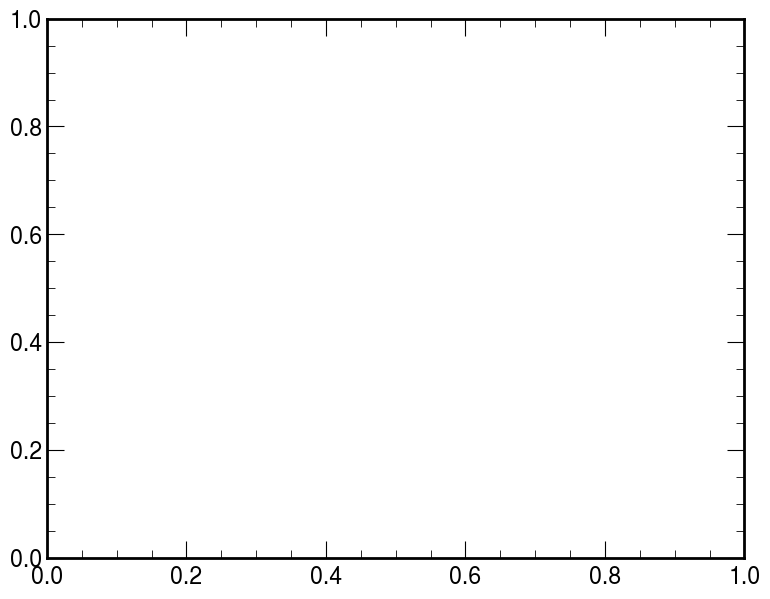

In [11]:
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf.json', 'r') as f:
    IN_perf = json.load(f)

# TPR_thresholds = [0.9704, 0.9498, 0.9196, 0.7536, 0.5777, 0.3837]
# print("Neural network performance")
# NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
# NNtable.float_format = ".4"
# for TPR_threshold in TPR_thresholds:
#     thres_idx = np.argmax(np.array(IN_perf['base_tpr'])>TPR_threshold)
#     NNtable.add_row(
#         [
#             IN_perf['mean_thresholds'][thres_idx], IN_perf['base_tpr'][thres_idx], 
#             "{:.4f} +/- {:.4f}".format(IN_perf['mean_fprs'][thres_idx], IN_perf['std_fprs'][thres_idx])
#         ]
#     )
# print(NNtable)

plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)

# plot_train_val_losses(
#     IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data',
#     labels=[str(i) for i in range(len(IN_perf['all_preds']))]
# )
# plot_roc(
#     IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', method='arr',
#     labels=[str(i) for i in range(len(IN_perf['all_preds']))]
# )
# plot_output_score(
#     IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', 
#     labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
#         'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
#     }
# )
s_over_root_b(
    IN_perf, plot_destdir+'/'+CURRENT_TIME, plot_postfix='_test_data', 
    labels=[str(i) for i in range(len(IN_perf['all_preds']))], weights={
        'bkg': data_test_aux.loc[label_test==0, "eventWeight"], 'sig': data_test_aux.loc[label_test==1, "eventWeight"]
    }
)

## Plotting

#### train + val comparison

In [10]:
IN_perf_dict = {'train': [], 'val': []}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
    IN_perf_dict['train'].append(
        evaluate(
            data_list[train_index], data_hlf[train_index], label[train_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx,
        )
    )
    IN_perf_dict['val'].append(
        evaluate(
            data_list[val_index], data_hlf[val_index], label[val_index], 
            OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf, only_fold_idx=fold_idx,
        )
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_train_val.json', 'w') as f:
    json.dump(IN_perf_dict, f)


##### ROC and Output Score Dist for train/val data

In [33]:
plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_train_val.json', 'r') as f:
    IN_perf_dict = json.load(f)

labels_arr = ['train - fold ', 'val - fold ']
for fold_idx, (train_IN_dict, val_IN_dict) in enumerate(zip(IN_perf_dict['train'], IN_perf_dict['val'])):
    plot_roc(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison_fold{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)]
    )
    plot_output_score(
        [train_IN_dict, val_IN_dict], plot_destdir+'/'+CURRENT_TIME, plot_postfix=f'_train_val_comparison{fold_idx}', 
        method='IN_arr', labels=[labels_arr[0]+str(fold_idx), labels_arr[1]+str(fold_idx)]
    )

##### Input Vars (pre-standardization and post-)

In [16]:
output_dir_pre_std = CURRENT_DIRPATH + f"/input_comparison/{VERSION}/pre_std/"
if not os.path.exists(output_dir_pre_std):
    os.makedirs(output_dir_pre_std)

pre_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    sig_mask = (label == 1)
    sig_test_mask = (label_test == 1)
    bkg_mask = (label == 0)
    bkg_test_mask = (label_test == 0)
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        
        sig_train_mask = rectified_train_index & sig_mask
        sig_val_mask = np.logical_not(rectified_train_index) & sig_mask
        bkg_train_mask = rectified_train_index & bkg_mask
        bkg_val_mask = np.logical_not(rectified_train_index) & bkg_mask

        sig_train_np = data_df.loc[sig_train_mask, var_name].to_numpy()
        sig_val_np = data_df.loc[sig_val_mask, var_name].to_numpy()
        sig_test_np = data_test_df.loc[sig_test_mask, var_name].to_numpy()
        bkg_train_np = data_df.loc[bkg_train_mask, var_name].to_numpy()
        bkg_val_np = data_df.loc[bkg_val_mask, var_name].to_numpy()
        bkg_test_np = data_test_df.loc[bkg_test_mask, var_name].to_numpy()

        sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_pre_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np = data_df.loc[sig_mask, var_name].to_numpy()
    sig_test_np = data_test_df.loc[sig_test_mask, var_name].to_numpy()
    bkg_train_np = data_df.loc[bkg_mask, var_name].to_numpy()
    bkg_test_np = data_test_df.loc[bkg_test_mask, var_name].to_numpy()
    sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    pre_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_pre_std, var_name, pre_std_hists[var_name], labels=label_arr)

In [17]:
output_dir_post_std = CURRENT_DIRPATH + f"/input_comparison/{VERSION}/post_std/"
if not os.path.exists(output_dir_post_std):
    os.makedirs(output_dir_post_std)

index_map = {
    var_name: data_list_index_map(var_name) for var_name in (high_level_fields - set(input_hlf_vars))
}
post_std_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    data, data_test = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        data, data_test = data_list, data_list_test
    else:
        data, data_test = data_hlf, data_hlf_test
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np 
        ) = post_std_np_arrays(
            data, data_test, var_name, index_map, 
            train_index=rectified_train_index, val_index=np.logical_not(rectified_train_index)
        )
        sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_post_std, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = post_std_np_arrays(data, data_test, var_name, index_map)

    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    post_std_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_post_std, var_name, post_std_hists[var_name], labels=label_arr)
    

#### Gaussian smearing on test set

In [18]:
def smear_particle_list(var_name, particle_list_to_smear, method='multiply', seed=SEED):
    index2, index3 = data_list_index_map(var_name)

    # Performs the smearing and returns the result
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_list_to_smear[:, index2, index3] *= rng.normal(size=len(particle_list_to_smear))
    elif method == 'add':
        particle_list_to_smear[:, index2, index3] += rng.normal(size=len(particle_list_to_smear))
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")

    return particle_list_to_smear


def smear_particle_hlf(var_name, particle_hlf_to_smear, method='multiply', seed=SEED):
    index2 = hlf_vars_columns[var_name]
    rng = np.random.default_rng(seed=seed)
    if method == 'multiply':
        particle_hlf_to_smear[:, index2] *= rng.normal(size=len(particle_hlf_to_smear))
    elif method == 'add':
        particle_hlf_to_smear[:, index2] += rng.normal(size=len(particle_hlf_to_smear))
    else:
        raise Exception(f"Only 'multiply' and 'add' are allowed as methods. You passed {method}.")
    
    return particle_hlf_to_smear

In [ ]:
IN_perf_smear_dict = {}
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
for var_name in high_level_fields:
    if var_name in {'event', 'eventWeight'}:
        continue
    gauss_data_list, gauss_data_hlf = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        gauss_data_list = smear_particle_list(var_name, copy.deepcopy(data_list_test))
        gauss_data_hlf = data_hlf_test
    else:
        gauss_data_list = data_list_test
        gauss_data_hlf = smear_particle_hlf(var_name, copy.deepcopy(data_hlf_test))

    IN_perf_smear_dict[var_name] = evaluate(
        gauss_data_list, gauss_data_hlf, label_test, OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf,
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'w') as f:
    json.dump(IN_perf_smear_dict, f)

##### ROC for gaussian smear variables

In [15]:
plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_gauss_smear.json', 'r') as f:
    IN_perf_smear_dict = json.load(f)
IN_perf_smear_list = []
label_arr = []
for var_name, IN_perf_smear in IN_perf_smear_dict.items():
    IN_perf_smear_list.append(IN_perf_smear)
    label_arr.append(var_name)
sort = np.argsort([IN_perf_smear['mean_area'] for IN_perf_smear in IN_perf_smear_list])
plot_roc(
    list(IN_perf_smear_dict.values()), plot_destdir+'/'+CURRENT_TIME, plot_postfix='_gauss_smear', 
    method='IN_arr', labels=label_arr, yscale='log', run2=False, sort=sort
)

##### Gaussian Smeared input Vars

In [19]:
output_dir_gauss_smear = CURRENT_DIRPATH + f"/input_comparison/{VERSION}/gauss_smear/"
if not os.path.exists(output_dir_gauss_smear):
    os.makedirs(output_dir_gauss_smear)

index_map = {
    var_name: data_list_index_map(var_name) for var_name in (high_level_fields - set(input_hlf_vars))
}
gauss_hists = {}
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test"
]
for var_name in high_level_fields:
    if var_name in {'event', 'puppiMET_eta'}:
        continue
    data, data_test = None, None
    if var_name in (high_level_fields - set(input_hlf_vars)):
        data, data_test = smear_particle_list(var_name, data_list), smear_particle_list(var_name, data_list_test)
    else:
        data, data_test = smear_particle_hlf(var_name, data_hlf), smear_particle_hlf(var_name, data_hlf_test)
    for fold_idx, (train_index, val_index) in enumerate(skf.split(data_hlf, label)):
        rectified_train_index = np.ones(len(label), dtype=bool)
        rectified_train_index[val_index] = False
        (
            sig_train_np, sig_val_np, sig_test_np, 
            bkg_train_np, bkg_val_np, bkg_test_np 
        ) = post_std_np_arrays(
            data, data_test, var_name, index_map, 
            train_index=rectified_train_index, val_index=np.logical_not(rectified_train_index)
        )
        sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
        sig_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_val_np[sig_val_np != 0])
        sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
        bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
        bkg_val_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_val_np[bkg_val_np != 0])
        bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])

        make_input_plot(
            output_dir_gauss_smear, var_name, 
            [sig_train_hist, sig_val_hist, sig_test_hist, bkg_train_hist, bkg_val_hist, bkg_test_hist], 
            fold_idx=fold_idx, labels=label_arr_fold
        )
    sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = post_std_np_arrays(data, data_test, var_name, index_map)

    sig_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_train_np[sig_train_np != 0])
    sig_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=sig_test_np[sig_test_np != 0])
    bkg_train_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_train_np[bkg_train_np != 0])
    bkg_test_hist = hist.Hist(VARIABLES_STD[var_name]).fill(var=bkg_test_np[bkg_test_np != 0])
    gauss_hists[var_name] = [
        copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
        copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
    ]
    make_input_plot(output_dir_gauss_smear, var_name, gauss_hists[var_name], labels=label_arr)

##### Mass sculpting

In [12]:
# with open('model_outputs/v0/BestConfigReallyTopclass.json', 'r') as f:
# with open(OUTPUT_DIRPATH + CURRENT_TIME + '_BestConfigReallyTopclass.json') as f:
with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v4/extra_vars/2024-08-20_23-02-48_BestConfigReallyTopclass.json') as f:
    best_conf = json.load(f)
IN_full_eval_dict = {}
for data_type, p_list, hlf, y in [('train', data_list, data_hlf, label), ('test', data_list_test, data_hlf_test, label_test)]:
    IN_full_eval_dict[data_type] = evaluate(
        p_list, hlf, y, 
        OUTPUT_DIRPATH, CURRENT_TIME, skf, best_conf,
    )

with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_full_eval.json', 'w') as f:
    json.dump(IN_full_eval_dict, f)

##### Mass dists with successive score cuts

In [9]:
plot_destdir = OUTPUT_DIRPATH + 'plots'
if not os.path.exists(plot_destdir):
    os.makedirs(plot_destdir)
with open(OUTPUT_DIRPATH + f'{CURRENT_TIME}_IN_perf_full_eval.json', 'r') as f:
    IN_full_eval_dict = json.load(f)

score_cuts = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]
label_arr = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train, score cut = ", MC_NAMES_PRETTY["GluGluToHH"]+" test, score cut = ",
    MC_NAMES_PRETTY["ttHToGG"]+" train, score cut = ", MC_NAMES_PRETTY["ttHToGG"]+" test, score cut = "
] * len(score_cuts)
label_arr = [label_arr[label_idx]+str(score_cuts[score_idx // (len(label_arr)//len(score_cuts))]) for score_idx, label_idx in enumerate(range(len(label_arr)))]
hist_dict = {'mass': [], 'dijet_mass': []}
for var_name in hist_dict.keys():
    for i, score_cut in enumerate(score_cuts):
        sig_train_np, sig_test_np, bkg_train_np, bkg_test_np = aux_np_arrays(var_name, score_cut, IN_full_eval_dict)
        sig_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_train_np)
        sig_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=sig_test_np)
        bkg_train_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_train_np)
        bkg_test_hist = hist.Hist(VARIABLES[var_name]).fill(var=bkg_test_np)
        hist_dict[var_name].extend(
            [
                copy.deepcopy(sig_train_hist), copy.deepcopy(sig_test_hist), 
                copy.deepcopy(bkg_train_hist), copy.deepcopy(bkg_test_hist)
            ]
        )
    for mod_factor, label_mod in enumerate(['sig_train', 'sig_test', 'bkg_train', 'bkg_test']):
        plot_list = []
        label_list = []
        for i in range(len(hist_dict[var_name])):
            if (i - mod_factor) % 4 == 0:
                plot_list.append(hist_dict[var_name][i])
                label_list.append(label_arr[i])
        make_input_plot(
            plot_destdir, var_name, plot_list, labels=label_list, density=True, 
            plot_prefix=CURRENT_TIME+'_', plot_postfix='_'+label_mod, alpha=0.5,
            linestyle=False
        )